<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

_Authors: Matt Brems, Sam Stack, Justin Pounders_

---

In this lab you will hone your exploratory data analysis (EDA) skills and practice constructing simple linear regressions using a data set on Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

%matplotlib inline

In [2]:
sac_csv = './datasets/sacramento_real_estate_transactions.csv'

In [3]:
# A:
sac = pd.read_csv(sac_csv)

In [4]:
sac.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


### 2. Conduct exploratory data analysis on this data set. 

**Report any notable findings here and any steps you take to clean/process data.**

> **Note:** These EDA checks should be done on every data set you handle. If you find yourself checking repeatedly for missing/corrupted data, it might be beneficial to have a function that you can reuse every time you're given new data.

In [5]:
# A:
sac.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

In [6]:
sac['zip'] = sac['zip'].astype(object)

In [7]:
sac['price'].min()
# nonsense

-210944

In [8]:
mask = sac['price'] < 0
#dropped row that included negative price value


In [9]:
sac.drop(sac.index[703], inplace=True)

In [10]:
mask_sqft = sac['sq__ft'] == 0

In [11]:
sac.loc[mask_sqft].head()
#some listings have listings with no physical space

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
73,17 SERASPI CT,SACRAMENTO,95834,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,206000,38.631481,-121.501880
89,2866 KARITSA AVE,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,244500,38.626671,-121.525970
100,12209 CONSERVANCY WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,263500,38.553867,-121.219141
121,5337 DUSTY ROSE WAY,RANCHO CORDOVA,95742,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,320000,38.528575,-121.228600
126,2115 SMOKESTACK WAY,SACRAMENTO,95833,CA,0,0,0,Residential,Wed May 21 00:00:00 EDT 2008,339500,38.602416,-121.542965


In [12]:
sac_cleaned_sqft = sac.drop(sac[mask_sqft].index) 
#getting rid of observations without sq__ft information

In [13]:
sac_cleaned_sqft.sq__ft.min()

484

_**Fun Fact:** Zip codes often have leading zeros — e.g., 02215 = Boston, MA — which will often get knocked off automatically by many software programs like Python or Excel. You can imagine that this could create some issues. _

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR model. 

**For each of the variables you believe to be a valid potential predictor in an SLR model, generate a plot showing the relationship between the independent and dependent variables.**

In [14]:
# A:
sac_cleaned_sqft.to_csv('./datasets/sacramento_real_estate_transactions_Clean.csv')

In [15]:
csac = sac_cleaned_sqft

In [16]:
csac.sq__ft.max()

5822

When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work.
```python
shd.to_csv('./datasets/sacramento_real_estate_transactions_Clean.csv')
```

### 4. Which variable would be the best predictor of Y in an SLR model? Why?

In [72]:
csac.columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'price', 'latitude', 'longitude', 'yhat', 'Multi-Family',
       'Residential'],
      dtype='object')

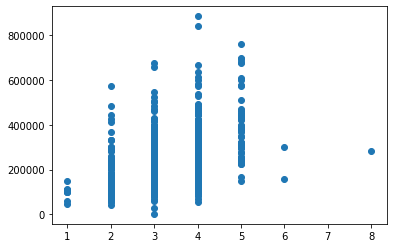

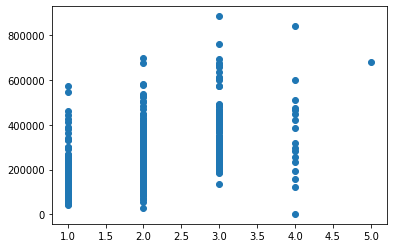

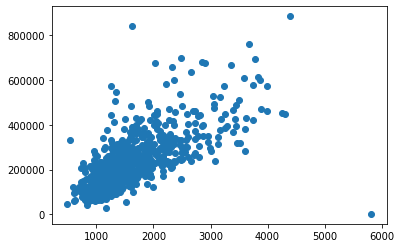

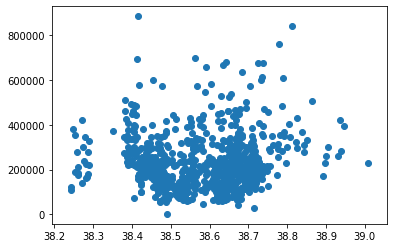

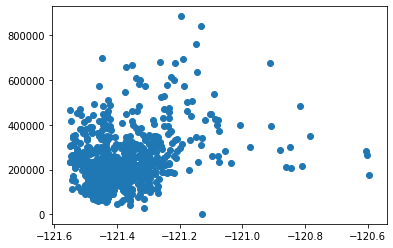

In [73]:
features = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
for col in features:
    plt.scatter(x=csac[col], y=csac['price'])  #plot 
    plt.show()

sq__ft, beds, and baths because those are more universal indicators of price than location

### 5. Build a function that will take in two lists, `Y` and `X`, and return the intercept and slope coefficients that minimize SSE. 

`Y` is the target variable and `X` is the predictor variable.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**

In [19]:
def interslope(df, list1, list2):
    y_bar = df[list2].mean()  #defining means
    x_bar = df[list1].mean()
    std_y = df[list2].std()   #defining standard deviations 
    std_x = df[list1].std()
    r_xy = df.corr().loc[list1, list2]  #setting up correlation matrix
    beta_1 = r_xy*(std_y/std_x)        #definition of B1
    beta_0 = y_bar - beta_1*x_bar        
    return beta_0, beta_1
beta_0, beta_1 = interslope(csac, 'sq__ft', 'price')
csac['yhat'] = beta_0 + beta_1 * csac['sq__ft']

In [20]:
beta_0

29984.36172651968

In [21]:
beta_1

125.31418257510147

### 6. Interpret the intercept. Interpret the slope.

For each unit increase by 1 square foot, the price
will increase on average by 125. The intercept has no direct meaning here (0 sqft means no house),
and is only there to keep the line from passing through the origin.


### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

Say that you want to build a spec house in ashbury, and want to know what it's eventual price will be.  
You can plug in the square feet of the house into the model to predict that price.  A realistic inference would be using the model to identify the present population mean price for ever increase in square footage.  

In [48]:
residuals = y - predictions

In [49]:
residuals.mean()

-7.44599844403519e-12

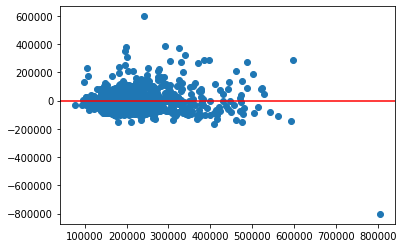

In [50]:
# Use np.random.randn to show what we expect in a residual plot
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red');

In [ ]:
#code from LR lesson 1
# A:# Create a figure.
plt.figure(figsize=(15,7))

# Generate a scatterplot of our data.
plt.scatter(csac['sq__ft'], csac['price'], c='k')

# Also generate a line for our prediction.
plt.plot(csac['price'], csac['yhat'], color='k');

# Iterate over our DataFrame, plotting a dashed line 
# from each observed value to its predicted value.
# Code originally written by Marc Harper.
for _, row in csac.iterrows():
    plt.plot((csac['sq__ft'], csac['price']),
             (row['sq__ft'], row['yhat']),
             'r--')

---

> The material following this point can be completed after the second lesson on Monday.

---

## Dummy Variables

---

It is important to be cautious with categorical variables, which represent distict groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [22]:
types = pd.get_dummies(csac['type'])

types.head()

,Condo,Multi-Family,Residential
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


---

### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occured in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tusday, Wednesday, Thursday, Friday or Saturday than it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to* is often referred to as the **reference category**.

### 10. Remove "Unknown" from four dummy coded variable dataframe and append the rest to the original data.

In [23]:
types.head()

,Condo,Multi-Family,Residential
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [24]:
csac['type'].unique()

array(['Residential', 'Condo', 'Multi-Family'], dtype=object)

In [25]:
types.drop('Condo', axis=1, inplace=True)

In [26]:
csac = csac.merge(types, left_index=True, right_index=True)


In [27]:
csac.head()


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,yhat,Multi-Family,Residential
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,134747.018359,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,176226.012792,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,129734.451056,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,136752.045281,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,129859.765239,0,1


### 11. Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three variables.* At least one of which should be a dummy-coded variable (either one we created before or a new one).

To construct your model don't forget to load in the statsmodels api:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

_I'm going to engineer a new dummy variable for 'HUGE houses'.  Those whose square footage is 3 (positive) standard deviations away from the mean._
```
Mean = 1315
STD = 853
Huge Houses > 3775 sq ft
```

In [28]:
y = csac['price']
X = csac[['beds','baths','sq__ft','Multi-Family','Residential']]

lm = linear_model.LinearRegression()

model = lm.fit(X, y)

predictions = model.predict(X)

In [29]:
lm.score(X, y)

0.4919323552037267

### 12. Plot the true price vs the predicted price to evaluate your MLR visually.

In [30]:
y_pred = model.predict(X)


In [31]:
model.intercept_

20518.289455842227

In [32]:
model.coef_

array([-14236.58021393,   8199.14340309,    130.58917767, -25000.68187979,
        33861.55142387])

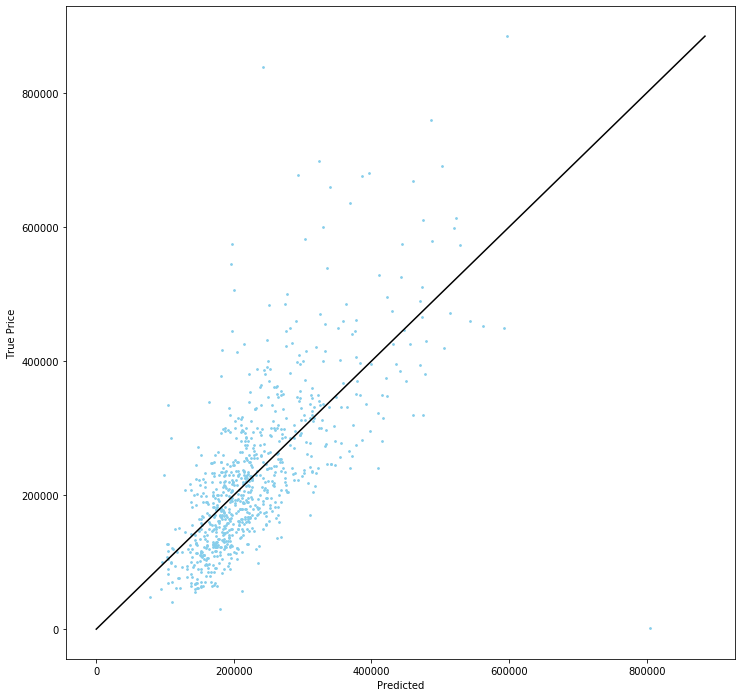

In [33]:
#Got this code from lesson 3.01
#Plot the model
plt.figure(figsize=(12,12))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y, c='skyblue', s=3)
plt.xlabel("Predicted")
plt.ylabel("True Price")

# This makes the 45 degree line
plt.plot([0, np.max(y)], [0, np.max(y)], c='k');

### 13. List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

**SLR AND MLR**:  

- *Linearity: Y must have an approximately linear relationship with each independent X_i.*
- *Independence: Errors (residuals) e_i and e_j must be independent of one another for any i != j.*
- *Normality: The errors (residuals) follow a Normal distribution.*
- *Equality of Variances: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the X_i. (There should be no discernable relationship between X_1 and the residuals.)*

**MLR ONLY**:  
- *Independence Part 2: The independent variables X_i and X_j must be independent of one another for any i != j*





### 14. Pick at least two assumptions and articulate whether or not you believe them to be met  for your model and why.

I believe that the linearity assumption is obeyed.  The price of a home has an approximatley linear relationship with the chosen features.

Independence part 2 may be violed because several features may be linked.  If a house is classified as 'Multi-Family', then it is gaurenteed to have more than one bedroom and likely more than one bathroom.  Not to mention I'm certain that all units considered 'Multi-Family' are all located in residential ares.  Additionaly the number of bedrooms affects the number of bathrooms.



### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

In [34]:
import statsmodels.api as sm

In [35]:
X.shape

(813, 5)

In [39]:
model = sm.OLS(y, X).fit() + 

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1320.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:06:02   Log-Likelihood:                -10386.
No. Observations:                 813   AIC:                         2.078e+04
Df Residuals:                     808   BIC:                         2.081e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
beds         -1.206e+04   5204.017     -2.317      0.021   -2.23e+04   -1840.161
baths         1.013e+04   6797.137      1.490      0.137   -3217.039    2.35e+04
sq__ft         129.2053      7.266     17.783      0.000     114.944     143.467
Multi-Family -1.731e+04   2.87e+04     -0.602      0.547   -7.37e+04    3.91e+04
Residential   4.563e+04   1.17e+04      3.896      0.000    2.26e+04    6.86e+04
==============================================================================
Omnibus:                      211.431   Durbin-Watson:                   1.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6507.386
Skew:                           0.482   Prob(JB):                         0.00
Kurtosis:                      16.826   Cond. No.                     1.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

> The material following this point can be completed after the first lesson on Tuesday.

---

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [41]:
def r2_adj(y, X):
    lr = LinearRegression() #initialize
    model = lr.fit(X, y)                 #train
    y_pred = model.predict(X)

    r_square = metrics.r2_score(y_pred, y)         #evaluate
    adj_r_squared = 1 - (1 - r_square)*(len(y)-1)/(len(y)-X.shape[1]-1) #formula for adjusted R^2   
    
    print(f"Adjusted R-squared: {adj_r_squared}")

### 17. Metrics, metrics, everywhere...

Write a function to calculate and print or return six regression metrics.  Use other functions liberally, including those found in `sklearn.metrics`.

In [63]:
def metric_scores(X, y):
    from sklearn import metrics 
    lr = LinearRegression() #initialize
    model = lr.fit(X, y)                 #train
    y_pred = model.predict(X)

   
    r_square = metrics.r2_score(y, y_pred)         #R-square
    adj_r_squared = 1 - (1 - r_square)*(len(y)-1)/(len(y)-X.shape[1]-1) #formula for adjusted R^2 
    mse =  metrics.mean_squared_error(y, y_pred) #mean square metric
    mae = metrics.mean_absolute_error(y, y_pred) #mean absolute error metric
    evs = metrics.explained_variance_score(y, y_pred) #explained variance metric
    maxerr = metrics.max_error(y, y_pred)            # max error
    mslr = metrics.mean_squared_log_error(y, y_pred)  #mean squared logarithmic error
    print(f'R squared score is: {r_square}')
    print(f"Adjusted R-squared score: {adj_r_squared}")
    print(f'Explained variance score is: {evs}') 
    print(f'max error is: {maxerr}')
    print(f'Mean Square Error is: {mse}')  
    print(f'Mean Absolute Error is: {mae}') 
    print(f'mean squared logaritmic error is: {mslr}')

### 18. Model Iteration

Evaluate your current home price prediction model by calculating all six regression metrics.  Now adjust your model (e.g. add or take away features) and see how to metrics change.

In [64]:
metric_scores(X, y)

R squared score is: 0.4919323552037267
Adjusted R-squared score: 0.4887844763636011
Explained variance score is: 0.4919323552037267
max error is: 802756.8662444258
Mean Square Error is: 7294706697.527724
Mean Absolute Error is: 59088.86475088256
mean squared logaritmic error is: 0.16603499410494255


In [60]:
X.columns

Index(['beds', 'baths', 'sq__ft', 'Multi-Family', 'Residential'], dtype='object')

In [61]:
X_2 = X[['beds', 'baths', 'sq__ft', 'Residential']]

In [65]:
metric_scores(X_2, y)

R squared score is: 0.49147471674222754
Adjusted R-squared score: 0.48895726484491187
Explained variance score is: 0.49147471674222754
max error is: 805018.3494783047
Mean Square Error is: 7301277354.770586
Mean Absolute Error is: 59079.03066276551
mean squared logaritmic error is: 0.16597402667341626


In [66]:
X_3 = X[['beds', 'baths', 'sq__ft']]
metric_scores(X_3, y)

R squared score is: 0.48482934022078183
Adjusted R-squared score: 0.4829189422240727
Explained variance score is: 0.48482934022078183
max error is: 800506.125367377
Mean Square Error is: 7396689989.515358
Mean Absolute Error is: 59708.2351047391
mean squared logaritmic error is: 0.16897364425275446


### 19. Bias vs. Variance

At this point, do you think your model is high bias, high variance or in the sweet spot?  If you are doing this after Wednesday, can you provide evidence to support your belief?

I believe that the model shows fairly low bias and variance for units that cost less than 400,000 dollars, but after that the model loses it's predictive power.